# Multivariate Time Series

Reference: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
%matplotlib inline

In [2]:
import datetime
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sklearn

2025-01-05 00:50:52.997104: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Raw Data Fetch

First few rows of the data:

```
No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
1,2010,1,1,0,NA,-21,-11,1021,NW,1.79,0,0
2,2010,1,1,1,NA,-21,-12,1020,NW,4.92,0,0
3,2010,1,1,2,NA,-21,-11,1019,NW,6.71,0,0
4,2010,1,1,3,NA,-21,-14,1019,NW,9.84,0,0
5,2010,1,1,4,NA,-20,-12,1018,NW,12.97,0,0
```

In [3]:
DATA_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv"

dataset = pd.read_csv(DATA_URL, index_col=0, parse_dates=[["year", "month", "day", "hour"]], date_format="%Y %m %d %H")

dataset.drop(columns="No", inplace=True)
# Rename columns
dataset.columns = ["pollution", "dew", "temp", "press", "wnd_dir", "wnd_spd", "snow", "rain"]
dataset.index.name = "hour"
# Cleanup: convert NaN values to 0
dataset["pollution"].fillna(0, inplace=True)
# Drop first 24h
dataset = dataset[24:]

dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
hour,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


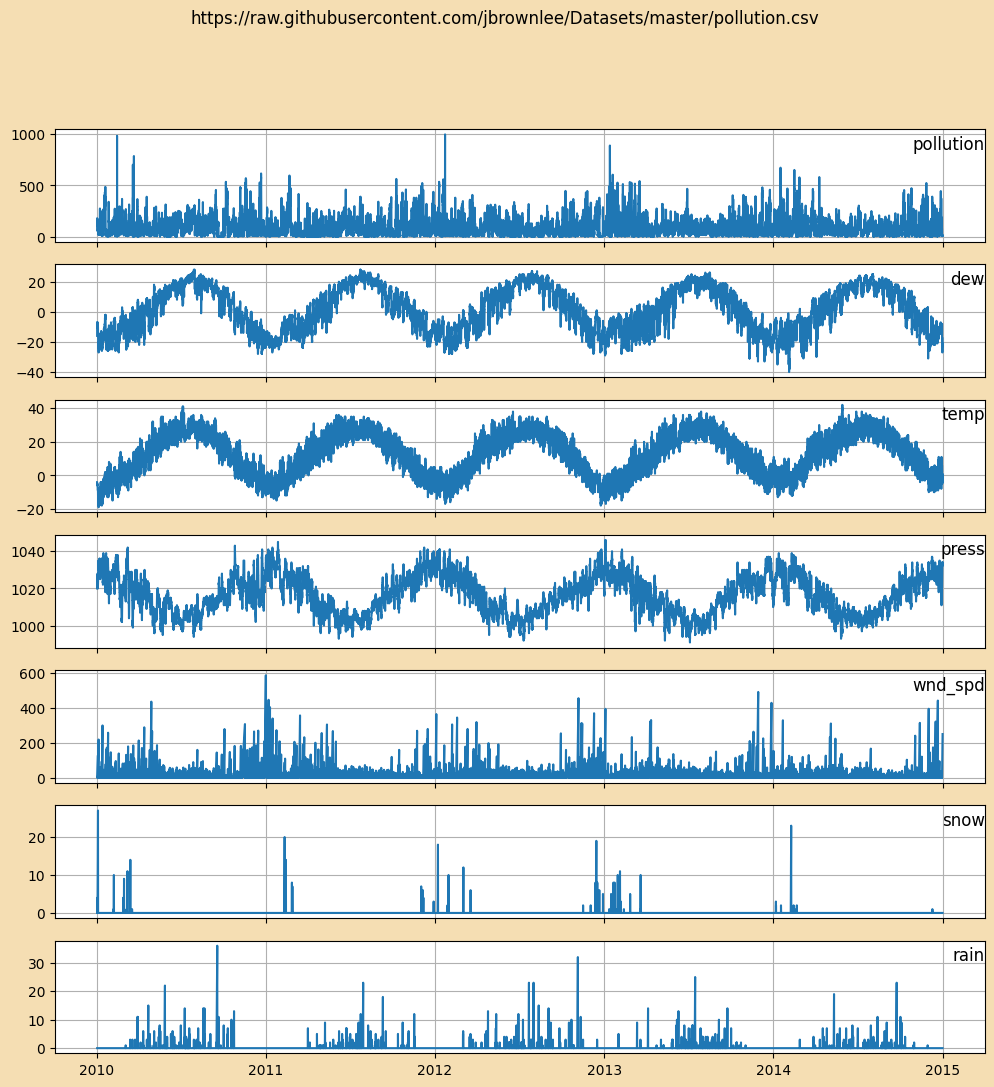

In [4]:
def plot_multi(data: pd.DataFrame, title: str, x_name: str, *columns: str) -> None:
    """Plots a stack of line charts."""
    figure = plt.figure(figsize=(12, 12), facecolor="wheat")
    figure.suptitle(DATA_URL)
    i = 1
    for col in columns:
        chart = figure.add_subplot(len(columns), 1, i)
        chart.set_title(col, loc="right", y=0.75)
        chart.grid(visible=True)
        if i < len(columns):
            chart.get_xaxis().set_tick_params(labelbottom=False)
        curve = chart.plot(data[col], label=col)
        i += 1

plot_multi(dataset, "Weather", "date", "pollution", "dew", "temp", "press", "wnd_spd", "snow", "rain")

## LSTM Data Preparation

LSTM will predict the current hour *t* given the conditions at *t-1*.

In [5]:
encoder = sklearn.preprocessing.LabelEncoder()
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))

In [6]:
# Convert the non-numeric wind direction into an integer-encoded numeric value.
dataset["wnd_dir"] = encoder.fit_transform(dataset["wnd_dir"])
# Convert numeric values to floats
dataset = dataset.astype("float32")

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float32
 1   dew        43800 non-null  float32
 2   temp       43800 non-null  float32
 3   press      43800 non-null  float32
 4   wnd_dir    43800 non-null  float32
 5   wnd_spd    43800 non-null  float32
 6   snow       43800 non-null  float32
 7   rain       43800 non-null  float32
dtypes: float32(8)
memory usage: 1.7 MB


In [8]:
# Create a scaled dataset
norm_data = dataset.copy()
print(type(norm_data["pollution"]))
for col in norm_data:
   norm_data[col] = scaler.fit_transform(norm_data[col].values.reshape((-1, 1)))
norm_data.info()
norm_data.head()

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float32
 1   dew        43800 non-null  float32
 2   temp       43800 non-null  float32
 3   press      43800 non-null  float32
 4   wnd_dir    43800 non-null  float32
 5   wnd_spd    43800 non-null  float32
 6   snow       43800 non-null  float32
 7   rain       43800 non-null  float32
dtypes: float32(8)
memory usage: 1.7 MB


,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
hour,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0


In [9]:
# convert series to supervised learning
def series_to_supervised(data: list|pd.DataFrame, n_in: int = 1, n_out: int = 1, dropnan: bool = True) -> pd.DataFrame:
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = []
    names = []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
reframed = series_to_supervised(norm_data, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

                     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
hour                                                                         
2010-01-02 01:00:00   0.129779   0.352941   0.245902   0.527273   0.666667   
2010-01-02 02:00:00   0.148893   0.367647   0.245902   0.527273   0.666667   
2010-01-02 03:00:00   0.159960   0.426471   0.229508   0.545454   0.666667   
2010-01-02 04:00:00   0.182093   0.485294   0.229508   0.563637   0.666667   
2010-01-02 05:00:00   0.138833   0.485294   0.229508   0.563637   0.666667   

                     var6(t-1)  var7(t-1)  var8(t-1)   var1(t)  
hour                                                            
2010-01-02 01:00:00   0.002290   0.000000        0.0  0.148893  
2010-01-02 02:00:00   0.003811   0.000000        0.0  0.159960  
2010-01-02 03:00:00   0.005332   0.000000        0.0  0.182093  
2010-01-02 04:00:00   0.008391   0.037037        0.0  0.138833  
2010-01-02 05:00:00   0.009912   0.074074        0.0  0.109658 

## Create Train and Test Sets

In [10]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


## Define Model

In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.LSTM(50))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')  # MAE = mean absolute error.

Fit the model.

In [12]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 4s - 36ms/step - loss: 0.0609 - val_loss: 0.0551
Epoch 2/50
122/122 - 1s - 12ms/step - loss: 0.0415 - val_loss: 0.0627
Epoch 3/50
122/122 - 1s - 12ms/step - loss: 0.0249 - val_loss: 0.0576
Epoch 4/50
122/122 - 1s - 11ms/step - loss: 0.0181 - val_loss: 0.0509
Epoch 5/50
122/122 - 2s - 13ms/step - loss: 0.0162 - val_loss: 0.0363
Epoch 6/50
122/122 - 2s - 13ms/step - loss: 0.0153 - val_loss: 0.0239
Epoch 7/50
122/122 - 2s - 13ms/step - loss: 0.0149 - val_loss: 0.0200
Epoch 8/50
122/122 - 1s - 11ms/step - loss: 0.0149 - val_loss: 0.0183
Epoch 9/50
122/122 - 1s - 11ms/step - loss: 0.0147 - val_loss: 0.0169
Epoch 10/50
122/122 - 1s - 11ms/step - loss: 0.0147 - val_loss: 0.0168
Epoch 11/50
122/122 - 1s - 11ms/step - loss: 0.0148 - val_loss: 0.0164
Epoch 12/50
122/122 - 1s - 11ms/step - loss: 0.0147 - val_loss: 0.0156
Epoch 13/50
122/122 - 2s - 15ms/step - loss: 0.0146 - val_loss: 0.0153
Epoch 14/50
122/122 - 2s - 16ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 15/50
122

In [13]:
print(type(history))

<class 'keras.src.callbacks.history.History'>


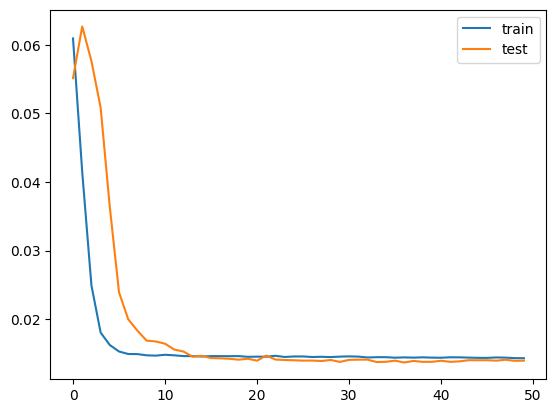

In [14]:
history_fig = plt.figure()
history_chart = history_fig.add_subplot()
history_chart.plot(history.history['loss'], label='train')
history_chart.plot(history.history['val_loss'], label='test')
history_chart.legend()

## Evaluate Model

Forecast for the entire dataset.

In [15]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Test RMSE: 0.975


In [16]:
print(type(inv_y), inv_y.shape)
print(len(dataset), len(dataset) - n_train_hours)

<class 'numpy.ndarray'> (35039,)
43800 35040


In [17]:
non_test = np.empty((n_train_hours + 1,))
non_test[:] = np.nan
hat_col = np.concatenate([non_test, inv_y])
dataset.drop("yhat", errors="ignore")
dataset["yhat"] = hat_col

In [18]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,yhat
hour,,,,,,,,,
2010-01-02 00:00:00,129.0,-16.0,-4.0,1020.0,2.0,1.79,0.0,0.0,NaN
2010-01-02 01:00:00,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,NaN
2010-01-02 02:00:00,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,NaN
2010-01-02 03:00:00,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,NaN
2010-01-02 04:00:00,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,NaN


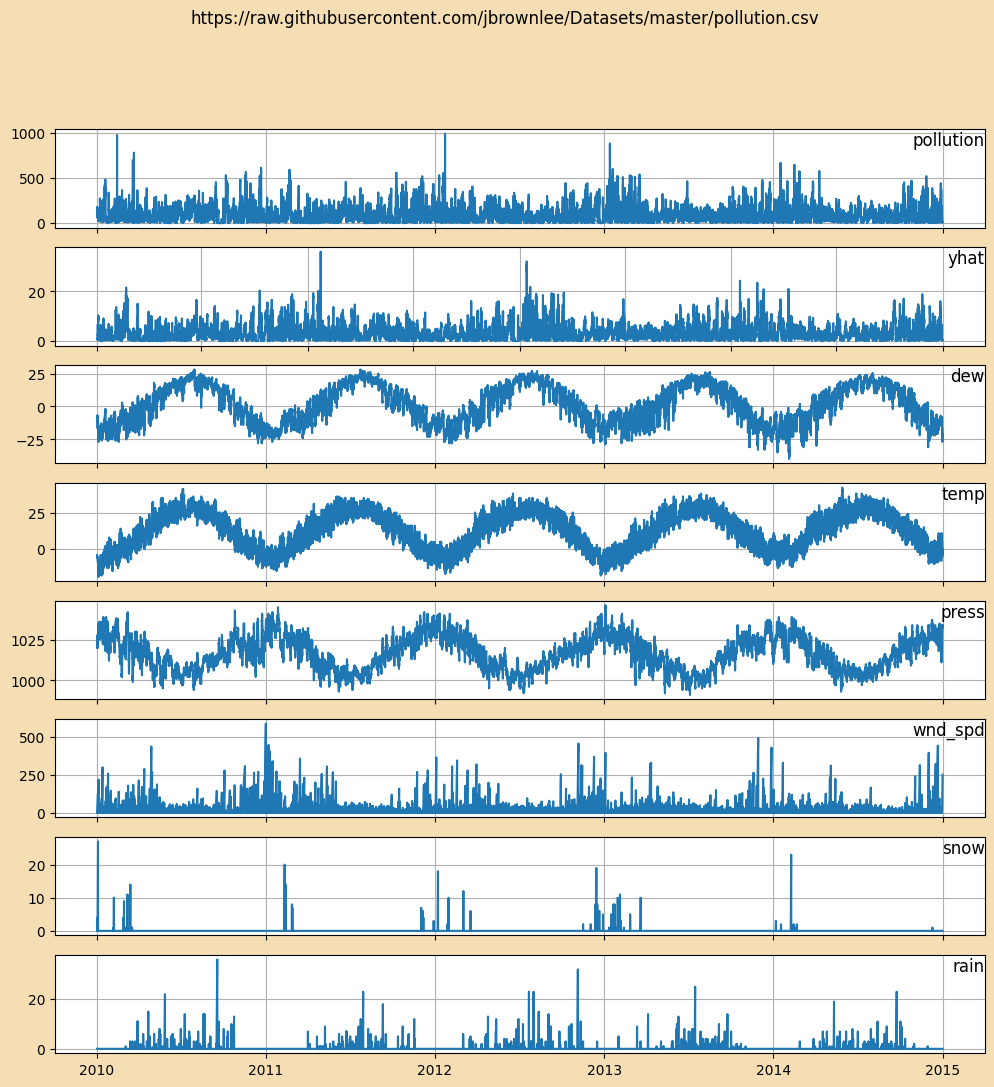

In [19]:
plot_multi(dataset, "Weather", "date", "pollution", "yhat", "dew", "temp", "press", "wnd_spd", "snow", "rain")